In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe
from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)
sys.path.append('label_axes')
from label_axes import label_axes

b
b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

In [4]:

model = em.ExponentialCustomTrialArray(unit_usrt1, good_indexes[0], em.trial_arrays['diff_array'])


In [4]:
witheld_scores1 = []
witheld_scores2 = []
witheld_scores3 = []
witheld_preds1 = []
witheld_preds2 = []
witheld_preds3 = []
red_preds1 = []
red_preds2 = []
red_preds3 = []
true_resp1 = []
true_resp2 = []
true_resp3 = []

for i in trange(32, position=0, leave=False):
    for ui in good_indexes:
        model1 = em.ExponentialCustomTrialArray(unit_usrt1, ui, em.trial_arrays['diff_array'])

        witheld_score, pred_red, pred_witheld = model1.fit_withold_trials(i)
        witheld_scores1.append(witheld_score)
        witheld_preds1.append(pred_witheld)
        red_preds1.append(pred_red)
        true_resp1.append(model1.true_resp)
        model2 = em.ExponentialCustomTrialArray(unit_usrt2, ui, em.trial_arrays['diff_array'])
        witheld_score, pred_red, pred_witheld= model2.fit_withold_trials(i)
        witheld_scores2.append(witheld_score)
        witheld_preds2.append(pred_witheld)
        red_preds2.append(pred_red)
        true_resp2.append(model2.true_resp)
        model3 = em.ExponentialCustomTrialArray(unit_usrt3, ui, em.trial_arrays['diff_array'])
        witheld_score, pred_red, pred_witheld = model3.fit_withold_trials(i)
        witheld_scores3.append(witheld_score)
        witheld_preds3.append(pred_witheld)
        red_preds3.append(pred_red)
        true_resp3.append(model3.true_resp)
witheld_scores1 = np.array(witheld_scores1).reshape(32, 130)
witheld_scores2 = np.array(witheld_scores2).reshape(32, 130)
witheld_scores3 = np.array(witheld_scores3).reshape(32, 130)

In [5]:
withheld_scores_joined = np.concatenate([witheld_scores1, witheld_scores2, witheld_scores3], axis=1)


In [6]:
witheld_order1 = np.argsort(np.median(np.log10(witheld_scores1), axis=1))
witheld_order2 = np.argsort(np.median(np.log10(witheld_scores2), axis=1))
witheld_order3 = np.argsort(np.median(np.log10(witheld_scores3), axis=1))
witheld_order_joined = np.argsort(np.median(np.log10(withheld_scores_joined), axis=1))

Text(0, 0.5, 'Log(Fit error)')

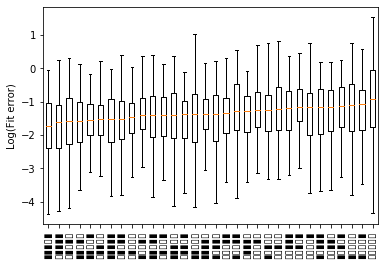

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(np.log10(witheld_scores1)[witheld_order1].T, showfliers=False);
ax.set_xticklabels(np.array(glyphs)[witheld_order1], rotation=90);
plt.ylabel('Log(Fit error)')

In [25]:
#print(witheld_scores.shape)
def plot_single_trial_removal_error(ax, witheld_scores, sort_order='median'):
    if sort_order == 'median':
        sort_index = np.argsort(np.median(witheld_scores, axis=1))
    elif sort_order == 'mean':
        sort_index = np.argsort(np.mean(witheld_scores, axis=1))
    
    ax.boxplot(witheld_scores[sort_index].T, showfliers=False)
    ax.set_xticklabels(np.array(glyphs)[sort_index], rotation=90, fontsize=5)
    ax.set_ylabel('Log(Fit error)')
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plot_single_trial_removal_error(ax, np.log10(witheld_scores))


NameError: name 'witheld_scores' is not defined

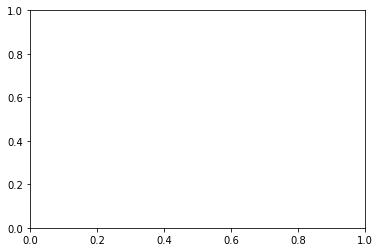

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_single_trial_removal_error(ax, np.log10(witheld_scores))

In [39]:
print(len(witheld_scores)/130)

31.0


In [26]:
increasing_scores = []
for ui in tqdm(good_indexes, leave=False, position=0):
    model1 = em.ExponentialCustomTrialArray(unit_usrt1, ui, em.trial_arrays['diff_array'])
    for i in range(100):
        trial_order = np.arange(32)
        np.random.shuffle(trial_order)
        for j in range(1, 32):
            witheld_score = np.mean(model1.fit_withold_trials(trial_order[:j]))
            increasing_scores.append(witheld_score)
increasing_scores = np.array(increasing_scores).reshape(44, 100, 31)

ValueError: operands could not be broadcast together with shapes (2,) (30,) 

In [15]:
removed_index = [31, 2]
trial_array = np.arange(32)
mask = np.full(32, True)
mask[removed_index] = False
removed_array = trial_array[mask]
print(removed_array)



[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [28]:
[1, 1, 1, 1, 1] @ model.opt_out.x[:5]

-0.18109844370992895

In [11]:
dasked = daskify.Daskified()
dasked.start_cluster()
client = dasked.client

/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38376 instead
  http_address["port"], self.http_server.port


In [12]:
def dask_increasing_witheld(unit_usrt_scattered, trial_array, ui, witheld_trials):
    model = em.ExponentialCustomTrialArray(unit_usrt_scattered, ui, trial_array)
    model_fit_scores, _, _ = model.fit_withold_trials(witheld_trials)
    witheld_score = np.mean(model_fit_scores)
    return witheld_score

In [17]:
dask_increasing_witheld(unit_usrt1, em.trial_arrays['diff_array'], good_indexes[0], [1,2,3,4,5])

0.2708930326206137

In [14]:
unit_usrt1_scattered = client.scatter(unit_usrt1)
diff_array_scattered = client.scatter(em.trial_arrays['diff_array'])

In [15]:
unit_usrt2_scattered = client.scatter(unit_usrt2)
unit_usrt3_scattered = client.scatter(unit_usrt3)

In [103]:
dask_delays = []
for ui in tqdm(good_indexes, leave=False, position=0):
    for i in range(100):
        trial_order = np.arange(32)
        np.random.shuffle(trial_order)
        for j in range(1, 32):
            dask_delays.append(dask.delayed(dask_increasing_witheld)(unit_usrt3_scattered, diff_array_scattered, ui, trial_order[:j]))



In [21]:
print(len(dask_delays))

403000


In [104]:
dask_outs = client.compute(dask_delays)
dasked.current_futures = dask_outs

In [108]:
dasked.check_progress()

finished 403000


In [27]:
dask_increasing_witheld(unit_usrt1, em.trial_arrays['diff_array'], ui, trial_order[:j])

4.951072244896314

In [39]:
removing_trials_res = np.array([i.result() for i in tqdm(dask_outs, leave=False, position=0)])

In [109]:
removing_trials_res3 = client.gather(dask_outs)

In [40]:
removing_trials_res = removing_trials_res.reshape(130, 100, 31)

In [102]:
removing_trials_res2 = np.array(removing_trials_res2).reshape(130, 100, 31)

In [110]:
removing_trials_res3 = np.array(removing_trials_res3).reshape(130, 100, 31)

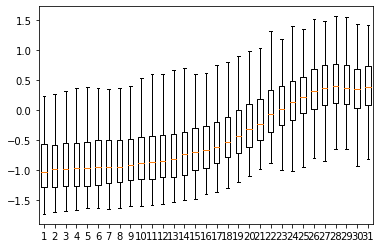

In [58]:
mean_removing_trials = np.mean(removing_trials_res, axis=1)
plt.boxplot(np.log10(mean_removing_trials), showfliers=False);


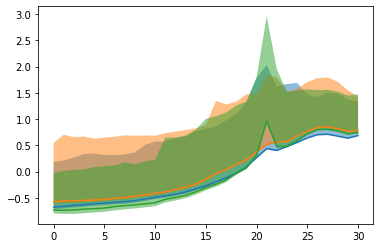

In [118]:
mean_removing_trials1 = np.mean(removing_trials_res, axis=1)
mean_removing_trials2 = np.mean(removing_trials_res2, axis=1)
mean_removing_trials3 = np.mean(removing_trials_res3, axis=1)

mins1 = np.log10(np.mean(mean_removing_trials1, axis=0) - np.min(mean_removing_trials1, axis=0))
maxs1 = np.log10(np.max(mean_removing_trials1, axis=0) - np.mean(mean_removing_trials1, axis=0))
mins2 = np.log10(np.mean(mean_removing_trials2, axis=0) - np.min(mean_removing_trials2, axis=0))
maxs2 = np.log10(np.max(mean_removing_trials2, axis=0) - np.mean(mean_removing_trials2, axis=0))
mins3 = np.log10(np.mean(mean_removing_trials3, axis=0) - np.min(mean_removing_trials3, axis=0))
maxs3 = np.log10(np.max(mean_removing_trials3, axis=0) - np.mean(mean_removing_trials3, axis=0))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(range(31), mins1, maxs1, alpha=0.5)
ax.plot(np.log10(mean_removing_trials1.mean(axis=0)));
ax.fill_between(range(31), mins2, maxs2, alpha=0.5)
ax.plot(np.log10(mean_removing_trials2.mean(axis=0)));
ax.fill_between(range(31), mins3, maxs3, alpha=0.5)
ax.plot(np.log10(mean_removing_trials3.mean(axis=0)));
plt.

In [135]:
joined_removing_res = np.array([removing_trials_res, removing_trials_res2, removing_trials_res3])
print(joined_removing_res.shape)

(3, 130, 100, 31)


In [136]:
np.save('230118_removing_trial_res.npy', joined_removing_res)

In [27]:
joined_removing_res = np.load('230118_removing_trial_res.npy')
removing_trials_res1 = joined_removing_res[0]
removing_trials_res2 = joined_removing_res[1]
removing_trials_res3 = joined_removing_res[2]

In [11]:
print(np.median(mean_removing_trials, axis=0))

NameError: name 'mean_removing_trials' is not defined

In [12]:
print(removing_trials_res1.shape)

(130, 100, 31)


test


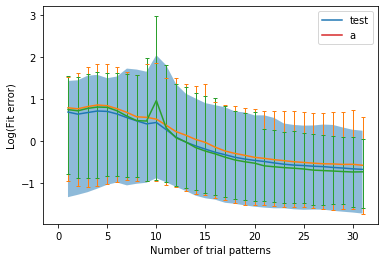

In [28]:
def plot_removing_trials_acc(ax, removing_trial_res, shaded=True, label=None):
    mean_trial = np.mean(removing_trial_res, axis=1)
    mean_mean_trial = np.mean(mean_trial, axis=0)

    mins = np.min(mean_trial, axis=0)
    maxs = np.max(mean_trial, axis=0)


    if shaded:
        print(label)
        ax.plot(range(1, len(mean_mean_trial)+1), np.log10(mean_mean_trial)[::-1], label=label)
        ax.fill_between(range(1, len(mean_mean_trial)+1), np.log10(mins[::-1]), np.log10(maxs[::-1]), alpha=0.5)
    else:
        mins = np.log10(mean_mean_trial) - np.log10(mins)
        maxs = np.log10(maxs)-np.log10(mean_mean_trial)
        ax.errorbar(range(1, len(mean_mean_trial)+1), np.log10(mean_mean_trial)[::-1], yerr=(mins[::-1], maxs[::-1]), elinewidth=1, capsize=2, label=label)
fig = plt.figure()
ax = fig.add_subplot(111)
plot_removing_trials_acc(ax, removing_trials_res1, shaded=True, label='test')
plot_removing_trials_acc(ax, removing_trials_res2, shaded=False)
plot_removing_trials_acc(ax, removing_trials_res3, shaded=False)
ax.set_xlabel('Number of trial patterns')
ax.set_ylabel('Log(Fit error)')

ax.plot([1], label='a')
ax.legend()

In [29]:
mins = np.mean(mean_removing_trials, axis=0) - np.min(mean_removing_trials, axis=0)
maxs = np.max(mean_removing_trials, axis=0) - np.mean(mean_removing_trials, axis=0)

plt.errorbar(range(31), np.log10(np.mean(mean_removing_trials, axis=0)), yerr=(np.log10(mins), np.log10(maxs)))


NameError: name 'mean_removing_trials' is not defined

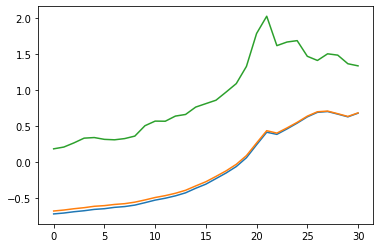

In [52]:
plt.plot(np.log10(mins))
plt.plot(np.log10(np.mean(mean_removing_trials, axis=0)))
plt.plot(np.log10(maxs))

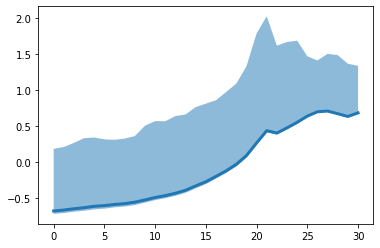

In [57]:
plt.fill_between(range(31), np.log10(mins), np.log10(maxs), alpha=0.5)
plt.plot(np.log10(np.mean(mean_removing_trials, axis=0)), linewidth=3)

In [30]:
bin1 = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
bin2 = [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31]
bin3 = [4, 5, 6, 7, 12, 13, 14, 15,20, 21, 22, 23, 28, 29, 30, 31]
bin4 = [8, 9, 10, 11, 12, 13, 14, 15, 24, 25, 26, 27, 28, 29, 30, 31]
bin5 = list(range(16, 32))
bin_removed = np.load('230119_trial_removed_bin_sets.npy')

In [31]:
def plot_unseen_trial_response(ax, model, legend=False):
    best_preds_red = []
    best_preds_with = []
    best_scores = []
    inserted_arrays = []
    for i in range(32):
        score, preds_red, preds_with = model.fit_withold_trials(i)
        best_scores.append(score)
        best_preds_red.append(preds_red)
        best_preds_with.append(preds_with)

    
    model.fit()
    ax.plot(model.true_resp, 'o', label='True resp')
    ax.plot(best_preds_with, 'o', label='Unseen prediction')
    ax.plot(model.pred_resp, 'o', label='Seen prediction')
    if legend:
        ax.legend()

In [32]:
cell_mean_removed_scores1 = np.mean(removing_trials_res1[:, :, 0], axis=1)
cell_mean_removed_scores2 = np.mean(removing_trials_res2[:, :, 0], axis=1)
cell_mean_removed_scores3 = np.mean(removing_trials_res3[:, :, 0], axis=1)
conc_scores = np.concatenate([cell_mean_removed_scores1, cell_mean_removed_scores2, cell_mean_removed_scores3])

print(np.argmin(conc_scores))
print(np.argmax(conc_scores))
print(np.where(conc_scores == np.quantile(conc_scores, 0.5, interpolation='nearest')))
best_fit_ui = good_indexes[222-130]
worse_fit_ui = good_indexes[253-130]
mid_fit_ui = good_indexes[340-260]

222
253
(array([340]),)


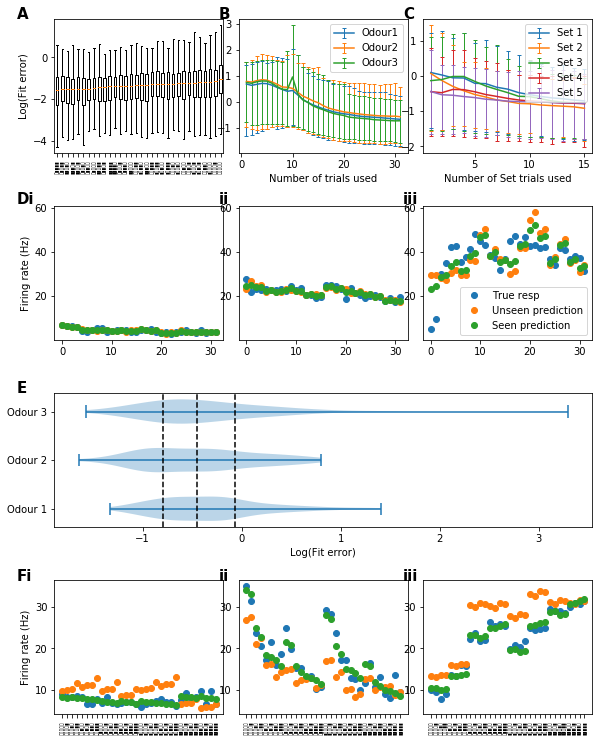

In [56]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(4, 6, left=0.05, right=0.95, top=0.95, hspace=0.4)
axes = []
single_trial_acc_ax = fig.add_subplot(gs[0, :2])
axes.append(single_trial_acc_ax)
plot_single_trial_removal_error(single_trial_acc_ax, np.log10(withheld_scores_joined))
number_of_trial_accs_ax = fig.add_subplot(gs[0, 2:4])
axes.append(number_of_trial_accs_ax)
plot_removing_trials_acc(number_of_trial_accs_ax, removing_trials_res1, shaded=False, label='Odour1')
plot_removing_trials_acc(number_of_trial_accs_ax, removing_trials_res2, shaded=False, label='Odour2')
plot_removing_trials_acc(number_of_trial_accs_ax, removing_trials_res3, shaded=False, label='Odour3')
number_of_trial_accs_ax.set_xlabel('Number of trials used')
number_of_trial_accs_ax.legend()

bin_group_removing_ax = fig.add_subplot(gs[0, 4:])
axes.append(bin_group_removing_ax)
plot_removing_trials_acc(bin_group_removing_ax, bin_removed[4], shaded=False, label='Set 1')
plot_removing_trials_acc(bin_group_removing_ax, bin_removed[3], shaded=False, label='Set 2')
plot_removing_trials_acc(bin_group_removing_ax, bin_removed[2], shaded=False, label='Set 3')
plot_removing_trials_acc(bin_group_removing_ax, bin_removed[1], shaded=False, label='Set 4')
plot_removing_trials_acc(bin_group_removing_ax, bin_removed[0], shaded=False, label='Set 5')
bin_group_removing_ax.legend()
bin_group_removing_ax.set_xlabel('Number of Set trials used')

best_fit_ui = good_indexes[222-130]
worse_fit_ui = good_indexes[253-130]
mid_fit_ui = good_indexes[340-260]
removed_trial_example_ax1 = fig.add_subplot(gs[1, :2])
removed_trial_example_ax2 = fig.add_subplot(gs[1, 2:4], sharey=removed_trial_example_ax1)
removed_trial_example_ax3 = fig.add_subplot(gs[1, 4:], sharey=removed_trial_example_ax1)
axes.append(removed_trial_example_ax1)
axes.append(removed_trial_example_ax2)
axes.append(removed_trial_example_ax3)
model_best = em.ExponentialCustomTrialArray(unit_usrt2, best_fit_ui, em.trial_arrays['diff_array'])
model_worst = em.ExponentialCustomTrialArray(unit_usrt2, worse_fit_ui, em.trial_arrays['diff_array'])
model_mid = em.ExponentialCustomTrialArray(unit_usrt3, mid_fit_ui, em.trial_arrays['diff_array'])

plot_unseen_trial_response(removed_trial_example_ax1, model_best)
plot_unseen_trial_response(removed_trial_example_ax2, model_mid)
plot_unseen_trial_response(removed_trial_example_ax3, model_worst, legend=True)
removed_trial_example_ax1.set_ylabel('Firing rate (Hz)')

pred_odour_dist_ax = fig.add_subplot(gs[2, :])
axes.append(pred_odour_dist_ax)
pred_odour_dist_ax.violinplot([log_pred_odor1, log_pred_odor2, log_pred_odor3], vert=False)
pred_odour_dist_ax.axvline(np.log10(low_quart), linestyle='--', color='k')
pred_odour_dist_ax.axvline(np.log10(mid_quart), linestyle='--', color='k')
pred_odour_dist_ax.axvline(np.log10(high_quart), linestyle='--', color='k')
pred_odour_dist_ax.set_xlabel('Log(Fit error)')
pred_odour_dist_ax.set_yticks(range(1, 4))
pred_odour_dist_ax.set_yticklabels(['Odour 1', 'Odour 2', 'Odour 3'])

pred_odour_exp_ax1 = fig.add_subplot(gs[3, :2])
pred_odour_exp_ax2 = fig.add_subplot(gs[3, 2:4], sharey=pred_odour_exp_ax1)
pred_odour_exp_ax3 = fig.add_subplot(gs[3, 4:6], sharey=pred_odour_exp_ax1)
axes.append(pred_odour_exp_ax1)
axes.append(pred_odour_exp_ax2)
axes.append(pred_odour_exp_ax3)


plot_pred_odour_fit(pred_odour_exp_ax1, full_models1[97], pred_odour_model25)
plot_pred_odour_fit(pred_odour_exp_ax2, full_models3[377-260], pred_odour_model50)
plot_pred_odour_fit(pred_odour_exp_ax3, full_models3[345-260], pred_odour_model75)
pred_odour_exp_ax1.set_ylabel('Firing rate (Hz)')

labels = ['A', 'B', 'C', 'Di', 'ii', 'iii', 'E', 'Fi', 'ii', 'iii']
label_axes.label_axes(axes, labels, fontsize=15, fontweight='bold', align_x=[[0,3, 6, 7], [1, 4, 8], [2, 5,9]], align_y=[[0, 1, 2], [3, 4, 5], [7, 8, 9]])

In [34]:
### Unseen odour
def pred_other_odour(model1, model2, model3, unit_usrt, ui, pred_trial = -1, ratio_schema = 'pred_trial', negative=False, exclude_t=True):
    full_array = em.trial_arrays['diff_array']
    if ratio_schema == 'pred_trial':
        ratio_w1 = model1.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
        ratio_w2 = model2.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
    elif ratio_schema == 'mean':
        ratio_w1 = np.mean(model1.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
        ratio_w2 = np.mean(model2.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
    elif ratio_schema == 'max':
        if model1.true_resp[-1] > model2.true_resp[-1]:
            ratio_w1 = 1
            ratio_w2 = 0
        else:
            ratio_w1 = 0
            ratio_w2 = 1
    elif ratio_schema == 'pred_trial_diff':
        model1_diff = abs(model1.true_resp[-1] - model1.true_resp[0])
        model2_diff = abs(model2.true_resp[-1] - model2.true_resp[0])
        ratio_w1 = model1_diff/(model1_diff+model2_diff)
        ratio_w2 = model2_diff/(model1_diff+model1_diff)
    if negative:
        ratio_w2 = -ratio_w2
    if exclude_t:
        pred_ws = model1.opt_out.x[:-1]*ratio_w1 + model2.opt_out.x[:-1]*ratio_w2
        avg_thresh = (model1.opt_out.x[-1] + model2.opt_out.x[-1])/2
        pred_out = pred_ws @ full_array[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]) - avg_thresh)/pred_out
        pred_ws = scale*pred_ws
        pred_ws = list(pred_ws) + [avg_thresh]
    else:
        pred_ws = model1.opt_out.x*ratio_w1 + model2.opt_out.x*ratio_w2
        full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
        pred_out = pred_ws @ full_array_1[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]))/pred_out
        pred_ws = scale*pred_ws
        

    
    model_test = em.ExponentialCustomTrialArray(unit_usrt, ui, full_array)
    model_test.fit(W=pred_ws)
    return model_test

In [35]:
full_models1 = np.array(pickle.Unpickler(open('221209_full_models1.pkl', 'rb')).load())[good_indexes]
full_models2 = np.array(pickle.Unpickler(open('221209_full_models2.pkl', 'rb')).load())[good_indexes]
full_models3 = np.array(pickle.Unpickler(open('221209_full_models3.pkl', 'rb')).load())[good_indexes]

In [18]:
pred_other_odour(full_models1[0], full_models2[0], full_models3[0], unit_usrt3, good_indexes[0])

In [36]:
pred_odours_score1 = []
pred_odours_score2 = []
pred_odours_score3 = []


for i in trange(130, position=0, leave=False):
    for ratio_schema in ['pred_trial', 'pred_trial_diff']:
        for exclude_t in [True, False]:
            for negative in [True, False]:
                pred_model1 = pred_other_odour(full_models2[i], full_models3[i], full_models1[i], unit_usrt1, good_indexes[i], ratio_schema=ratio_schema, exclude_t=exclude_t, negative=negative)
                pred_model2 = pred_other_odour(full_models1[i], full_models3[i], full_models2[i], unit_usrt2, good_indexes[i], ratio_schema=ratio_schema, exclude_t=exclude_t, negative=negative)
                pred_model3 = pred_other_odour(full_models2[i], full_models1[i], full_models3[i], unit_usrt3, good_indexes[i], ratio_schema=ratio_schema, exclude_t=exclude_t, negative=negative)
                pred_odours_score1.append(pred_model1.fit_score)
                pred_odours_score2.append(pred_model2.fit_score)
                pred_odours_score3.append(pred_model3.fit_score)


In [37]:
pred_odours_score1 = np.array(pred_odours_score1).reshape(130, 2, 2, 2)
pred_odours_score2 = np.array(pred_odours_score2).reshape(130, 2, 2, 2)
pred_odours_score3 = np.array(pred_odours_score3).reshape(130, 2, 2, 2)

pred_odours_score1 = np.min(pred_odours_score1, axis=-1)
pred_odours_score2 = np.min(pred_odours_score2, axis=-1)
pred_odours_score3 = np.min(pred_odours_score3, axis=-1)

pred_odours_score1_flatten  = pred_odours_score1.reshape(130, -1)
pred_odours_score2_flatten  = pred_odours_score2.reshape(130, -1)
pred_odours_score3_flatten  = pred_odours_score3.reshape(130, -1)

In [38]:
## pred odour further work
full_responding_units = []
for i in range(130):
    model1 = full_models1[i]
    model2 = full_models2[i]
    model3 = full_models3[i]
    
    odour1_resp_diff = abs(model1.true_resp[0] - model1.true_resp[-1])
    odour2_resp_diff = abs(model2.true_resp[0] - model2.true_resp[-1])
    odour3_resp_diff = abs(model3.true_resp[0] - model3.true_resp[-1])
    
    odour1_var = np.sqrt(model1.unit_sr_var[0])
    odour2_var = np.sqrt(model2.unit_sr_var[0])
    odour3_var = np.sqrt(model3.unit_sr_var[0])
    if i == 41:
        print(odour1_resp_diff, odour1_var)
    if odour1_resp_diff > odour1_var and odour2_resp_diff > odour2_var and odour3_resp_diff > odour3_var:
        full_responding_units.append(i)

10.0 5.259488779550939


In [220]:
print(len(full_responding_units))

44


In [39]:
log_pred_odor1 = np.log10(pred_odours_score1[:, 0, 1])
log_pred_odor2 = np.log10(pred_odours_score2[:, 0, 1])
log_pred_odor3 = np.log10(pred_odours_score3[:, 0, 1])

Text(0, 0.5, 'Log(Fit error)')

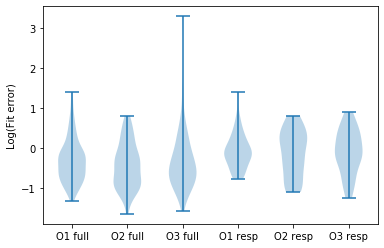

In [64]:
plt.violinplot([np.log10(pred_odours_score1[:, 0, 1]), np.log10(pred_odours_score2[:, 0, 1]), np.log10(pred_odours_score3[:, 0, 1]),
               np.log10(pred_odours_score1[full_responding_units, 0, 1]), 
                np.log10(pred_odours_score2[full_responding_units, 0, 1]), 
                np.log10(pred_odours_score3[full_responding_units, 0, 1])])
plt.xticks(range(1, 7), labels=['O1 full', 'O2 full', 'O3 full', 'O1 resp', 'O2 resp', 'O3 resp'])
plt.ylabel('Log(Fit error)')

In [62]:
print(ttest_ind(np.log10(pred_odours_score1[:, 0, 1]), np.log10(pred_odours_score1[full_responding_units, 0, 1])))
print(ttest_ind(np.log10(pred_odours_score2[:, 0, 1]), np.log10(pred_odours_score2[full_responding_units, 0, 1])))
print(ttest_ind(np.log10(pred_odours_score3[:, 0, 1]), np.log10(pred_odours_score3[full_responding_units, 0, 1])))
print(np.log10(pred_odours_score1[:, 0, 1]).mean(), np.log10(pred_odours_score1[full_responding_units, 0, 1]).mean())

Ttest_indResult(statistic=-2.5998646114849686, pvalue=0.010136899752896708)
Ttest_indResult(statistic=-2.9442473870739003, pvalue=0.003685177630689253)
Ttest_indResult(statistic=-2.480856113413282, pvalue=0.014068013537777183)
-0.3083149347784576 -0.07313843102967078


In [43]:
joined_dist = np.concatenate([pred_odours_score1[:, 0, 1], pred_odours_score2[:, 0, 1], pred_odours_score3[:, 0, 1]])

In [44]:
print(np.where(joined_dist == np.quantile(joined_dist, 0.25, interpolation='nearest'))[0][0])
print(np.where(joined_dist == np.quantile(joined_dist, 0.5, interpolation='nearest'))[0][0])
print(np.where(joined_dist == np.quantile(joined_dist, 0.75, interpolation='nearest'))[0][0])

97
377
345


In [45]:
low_quart= np.quantile(joined_dist, 0.25, interpolation='nearest')
mid_quart= np.quantile(joined_dist, 0.5, interpolation='nearest')
high_quart= np.quantile(joined_dist, 0.75, interpolation='nearest')

In [46]:
pred_odour_model25 = pred_other_odour(full_models2[97], full_models3[97], full_models1[97], unit_usrt1, good_indexes[97])
pred_odour_model50 = pred_other_odour(full_models1[377-260], full_models2[377-260], full_models3[377-260], unit_usrt3, good_indexes[377-260])
pred_odour_model75 = pred_other_odour(full_models1[345-260], full_models2[345-260], full_models3[345-260], unit_usrt3, good_indexes[345-260])

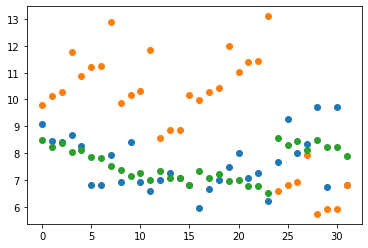

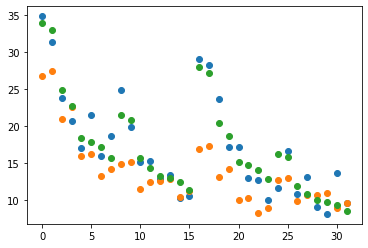

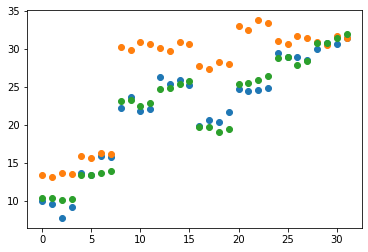

In [253]:
full_models1[97].fit()
full_models3[377-260].fit()
full_models3[345-260].fit()
plt.plot(pred_odour_model25.true_resp, 'o')
plt.plot(pred_odour_model25.pred_resp, 'o')
plt.plot(full_models1[97].pred_resp, 'o')
plt.figure()
plt.plot(pred_odour_model50.true_resp, 'o')
plt.plot(pred_odour_model50.pred_resp, 'o')
plt.plot(full_models3[377-260].pred_resp, 'o')
plt.figure()
plt.plot(pred_odour_model75.true_resp, 'o')
plt.plot(pred_odour_model75.pred_resp, 'o')
plt.plot(full_models3[345-260].pred_resp, 'o')

In [48]:
def plot_pred_odour_fit(ax, full_model, odour_model):
    full_model.fit()
    ax.plot(odour_model.true_resp, 'o')
    ax.plot(odour_model.pred_resp, 'o')
    ax.plot(full_model.pred_resp, 'o')
    ax.set_xticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90, fontsize=5)

In [210]:
for i in range(3):
    for j in range(i+1, 4):
        print(ttest_ind(pred_odours_score1_flatten[:, i], pred_odours_score1_flatten[:, j]))
        print(ttest_ind(pred_odours_score2_flatten[:, i], pred_odours_score2_flatten[:, j]))
        print(ttest_ind(pred_odours_score3_flatten[:, i], pred_odours_score3_flatten[:, j]))
        print('\n')

Ttest_indResult(statistic=0.6787581685669609, pvalue=0.4978994970330909)
Ttest_indResult(statistic=0.7249790459129539, pvalue=0.46912188521900267)
Ttest_indResult(statistic=-1.002433643586263, pvalue=0.3170734375879851)


Ttest_indResult(statistic=0.18857395845167285, pvalue=0.8505749892965596)
Ttest_indResult(statistic=-0.9716149796330014, pvalue=0.3321521476586805)
Ttest_indResult(statistic=0.14875931236255419, pvalue=0.8818597638280039)


Ttest_indResult(statistic=-1.2336456290970161, pvalue=0.2184576489059235)
Ttest_indResult(statistic=-2.3049076476496997, pvalue=0.021965980714906234)
Ttest_indResult(statistic=-1.0059771291125998, pvalue=0.3153691134748929)


Ttest_indResult(statistic=-0.5508893987633526, pvalue=0.5821862060562542)
Ttest_indResult(statistic=-1.0549073272806964, pvalue=0.29245457184884266)
Ttest_indResult(statistic=1.0060877908641381, pvalue=0.31531598571024466)


Ttest_indResult(statistic=-1.2336456975201169, pvalue=0.2184576234409442)
Ttest_indResult(statistic=-2.